In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, BatchNormalization

import os 
import cv2

LOADING THE DATASET

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d "ananthu017/emotion-detection-fer"

 83% 54.0M/65.2M [00:00<00:00, 160MB/s]
100% 65.2M/65.2M [00:00<00:00, 151MB/s]


In [ ]:
!unzip emotion-detection-fer.zip

In [ ]:
!mkdir emotion_data

In [ ]:
!mv train/ emotion_data/
!mv test/ emotion_data/

In [ ]:
!rm -rf emotion_data/train/disgusted/
!rm -rf emotion_data/train/fearful/

!rm -rf emotion_data/test/disgusted/
!rm -rf emotion_data/test/fearful/

LET'S SEE SOME IMAGES

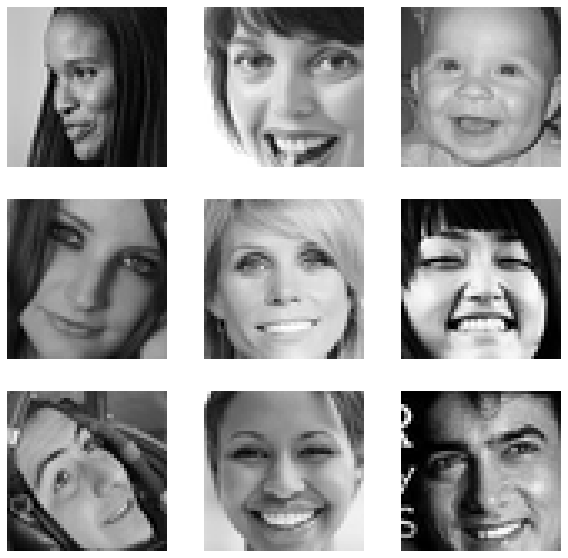

In [ ]:
happy_folder="emotion_data/train/happy/"
happy_images=[]
i=0
for filename in os.listdir(happy_folder):
  img=cv2.imread(happy_folder+filename)
  happy_images.append(img)
  i+=1
  if i==9:
    break

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(happy_images[i])
    plt.axis("off")

IMAGE PREPROCESSING

In [ ]:
generator=keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_generator=generator.flow_from_directory("emotion_data/train",
                                              target_size=(48,48),
                                              batch_size=64,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              )

test_generator=generator.flow_from_directory("emotion_data/test",
                                              target_size=(48,48),
                                              batch_size=64,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              )

print(train_generator.class_indices)

Found 24176 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprised': 4}


CLASS WEIGHTS COMPUTING

In [ ]:
#how many data for each category?
hpc=[]
cat=[]
for category in os.listdir("emotion_data/train/"):
  cat.append(category)
  hpc.append( len([name for name in os.listdir('emotion_data/train/'+category)])   )

dhpc=dict(zip(cat,hpc))
print(dhpc)

{'sad': 4830, 'angry': 3995, 'neutral': 4965, 'happy': 7215, 'surprised': 3171}


In [ ]:
#set the class weights

tot=sum(hpc)

cw=[ tot/(len(cat)*dhpc[el]) for el in dhpc]

class_weight=dict(zip( [train_generator.class_indices[el] for el in dhpc], cw ))
print(class_weight)

{3: 1.0010766045548654, 0: 1.2103128911138923, 2: 0.9738569989929506, 1: 0.6701593901593902, 4: 1.52481866918953}


MODEL DEFINITION AND TRAINING

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, BatchNormalization

model=Sequential([
    Conv2D(filters=128, kernel_size=8,padding='same',activation='relu',input_shape=[48,48,1]),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(filters=256,kernel_size=4,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(filters=512,kernel_size=4,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(filters=512,kernel_size=4,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Flatten(),
    Dense(512,activation='selu',kernel_initializer='lecun_normal'),
    Dropout(0.4),
    Dense(256,activation='selu',kernel_initializer='lecun_normal'),
    Dropout(0.4),
    Dense(256,activation='selu',kernel_initializer='lecun_normal'),
    Dropout(0.4),
    Dense(5,activation='softmax')
])

checkpoint_cb=keras.callbacks.ModelCheckpoint("my_keras_model.h5")
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])
history=model.fit(train_generator,validation_data=test_generator, class_weight=class_weight,
                  epochs=15,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/15
378/378 [==============================] - 28s 72ms/step - loss: 2.6397 - accuracy: 0.2213 - val_loss: 1.6256 - val_accuracy: 0.2914
Epoch 2/15
378/378 [==============================] - 27s 71ms/step - loss: 1.6405 - accuracy: 0.2959 - val_loss: 1.5871 - val_accuracy: 0.3331
Epoch 3/15
378/378 [==============================] - 27s 71ms/step - loss: 1.3825 - accuracy: 0.4005 - val_loss: 1.5959 - val_accuracy: 0.3760
Epoch 4/15
378/378 [==============================] - 27s 72ms/step - loss: 1.2054 - accuracy: 0.4999 - val_loss: 1.5976 - val_accuracy: 0.3507
Epoch 5/15
378/378 [==============================] - 27s 72ms/step - loss: 1.0980 - accuracy: 0.5556 - val_loss: 1.3059 - val_accuracy: 0.4815
Epoch 6/15
378/378 [==============================] - 27s 72ms/step - loss: 1.0135 - accuracy: 0.6003 - val_loss: 1.2328 - val_accuracy: 0.4913
Epoch 7/15
378/378 [==============================] - 27s 72ms/step - loss: 0.9299 - accuracy: 0.6416 - val_loss: 1.0526 - val_accuracy:

CONFUSION MATRIX

Found 6043 images belonging to 5 classes.


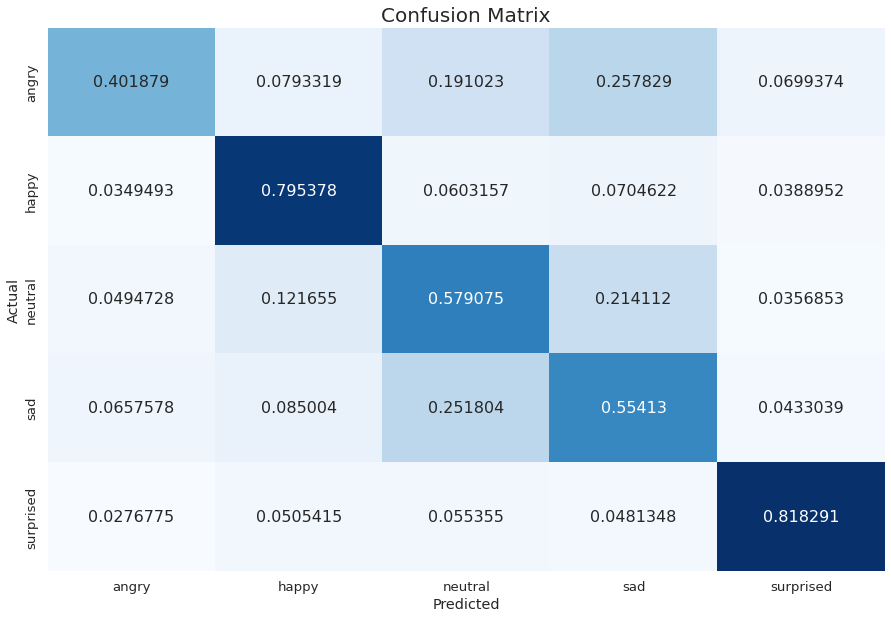

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_generator_ordered=generator.flow_from_directory("emotion_data/test",
                                              target_size=(48,48),
                                              batch_size=64,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              shuffle=False
                                              )

preds = model.predict(test_generator_ordered)
y_pred = np.argmax(preds,axis=1)
y_test=test_generator_ordered.classes

CLASS_LABELS  = ['angry', 'happy', 'neutral', 'sad', 'surprised']

cm_data = confusion_matrix(y_test, y_pred,normalize='true')
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')